In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# CSC380 Decision Tree Classifier Project

<div>
        Members: Sebastian Arana and Austin Baber
</div>

In [2]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")

### Imports and globals
<div>We are using scikit-learn, numpy, pandas, matplotlib</div>

In [3]:
import pandas as pd
import math
import os

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

MIN_SUPPORT = 10 # per spec
MAX_TREE_HEIGHT = None # computed dynamically

def set_max_tree_height(num_classes):
    """set MAX_TREE_HEIGHT based on number of classes"""
    global MAX_TREE_HEIGHT
    MAX_TREE_HEIGHT = math.ceil(math.log2(num_classes)) + 1
    print(f"MAX_TREE_HEIGHT set to {MAX_TREE_HEIGHT} for m = {num_classes} classes.")


### Step 1
<div>Parse train/ test data</div>

In [4]:
def load_dataset(path, label = "Class"):
    df = pd.read_csv(path)

    # skip stray index columns
    df = df.loc[:, ~df.columns.str.lower().str.startswith("unnamed")] # bitwise NOT

    y = pd.to_numeric(df[label], errors="raise").astype(int).to_numpy()
    X = df.drop(columns=[label]).astype(float).to_numpy()
    return X, y

### Step 2
<div>Find best split using gini score (logic based on predictive lecture 2 slides)</div>

In [5]:
def gini_impurity(y):
    """compute impurity for labels y"""
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts = True)
    p = counts / counts.sum()
    return 1 - np.sum(p**2)

def gini_score(y_left, y_right):
    """weighted impurity of a split"""
    n = len(y_left) + len(y_right)
    return (len(y_left)/n) * gini_impurity(y_left) + (len(y_right)/n) * gini_impurity(y_right)

def combinations(classes):
    """returns all r = 1 and r = 2 combinations, up to m = 9"""
    """copy/pasted from previous hw assignment"""
    m = len(classes)
    combination_list = []
    for i in classes: # r = 1
        combination_list.append((i,))
    for i in range(m): # r = 2
        for j in range(i + 1, m):
            combination_list.append((classes[i], classes[j]))
    return combination_list    

def best_split(X, y, linear = True):
    """
    try all groupings, fit an SVM, and pick the best split by gini score
    Returns: best_clf, left_idx, right_idx
    """
    classes = list(np.unique(y))
    combination_list = combinations(classes)

    best_gini = 1.0
    best_clf = None
    best_left_idx, best_right_idx = None, None

    for group in combination_list:
        # binary labels: 1 if in group, else 0
        y_binary = np.isin(y, group).astype(int)

        # skip if all same label
        if len(np.unique(y_binary)) < 2:
            continue

        # train SVM
        kernel = 'linear' if linear else 'rbf'
        clf = SVC(kernel = kernel, C=1)
        clf.fit(X, y_binary)

        # split data based on decision function
        decision_vals = clf.decision_function(X)
        left_idx = decision_vals >= 0
        right_idx = ~left_idx # bitwise NOT

        # compute gini
        gini = gini_score(y[left_idx], y[right_idx])

        # we want lower gini
        if gini < best_gini:
            best_gini = gini
            best_clf = clf
            best_left_idx = left_idx
            best_right_idx = right_idx

    return best_clf, best_left_idx, best_right_idx


### Step 3
<div>Build tree</div>

In [52]:
class Node:
    def __init__(self):
        self.is_leaf = False
        self.label = None
        self.clf = None
        self.left = None
        self.right = None
        
def build_tree(X, y, depth = 0, max_depth = None, min = 10, linear = True):
    node = Node()

    # base case
    if depth >= MAX_TREE_HEIGHT or len(np.unique(y)) == 1 or len(y) < MIN_SUPPORT:
        node.is_leaf = True
        node.label = np.bincount(y).argmax()
        return node

    # find best split
    clf, left_idx, right_idx = best_split(X, y, linear = linear)

    # if none, make leaf
    if clf is None:
        node.is_leaf = True
        node.label = np.bincount(y).argmax()
        return node

    print("Node is not a leaf")  # ======================================= UNREACHABLE
    node.clf = clf
    node.left = build_tree(X[left_idx], y[left_idx], depth+1, MAX_TREE_HEIGHT, MIN_SUPPORT, linear)
    node.right = build_tree(X[right_idx], y[right_idx], depth+1, MAX_TREE_HEIGHT, MIN_SUPPORT, linear)
    return node

### Step 4
<div>Make predictions</div>

In [53]:
def predict1(node, x):
    """traverse tree to predict label for a sample"""
    if node.is_leaf:
        return node.label
    print("THIS NODE IS NOT A LEAF")  # ======================================== UNREACHABLE CODE
    decision_val = node.clf.decision_function([x])[0]
    print(decision_val)
    if decision_val >= 0:
        return predict1(node.left, x)
    else:
        return predict1(node.right, x)

def predict(node, X):
    return np.array([predict1(node, x) for x in X])

### Wrapper for modularization per dataset

In [54]:
def train_and_eval(train_csv, test_csv, linear = True):
    X_train, y_train = load_dataset(train_csv)
    X_test, y_test = load_dataset(test_csv)

    # update tree height for this dataset
    set_max_tree_height(len(np.unique(y_train)))

    #m = len(np.unique(y_train))
    #max_depth = math.ceil(math.log2(m)) + 1

    clf, left_idx, right_idx = best_split(X_train, y_train, linear=linear)

    tree = build_tree(X_train, y_train, MAX_TREE_HEIGHT, MIN_SUPPORT, linear = linear)
    y_pred = predict(tree, X_test)
    acc = accuracy_score(y_test, y_pred)
    return tree, acc, MAX_TREE_HEIGHT, X_test, y_test


### Interactive Plot

In [56]:
def interactive_plot(tree, X, y):
    
    fig, ax = plt.subplots()
    
    # Plot training data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title("Click to predict with Decision Tree (SVM splits)")

    node = tree
    while not node.is_leaf:
        clf = node.clf
        # Plot boundaries
        minX0D = np.min(X[:, 0])
        maxX0D = np.max(X[:, 0])
        minX1D = np.min(X[:, 1])
        maxX1D = np.max(X[:, 1])
        minX1 = (-clf.intercept_-clf.coef_[0,0]*minX0D)/clf.coef_[0,1]
        maxX1 = (-clf.intercept_-clf.coef_[0,0]*maxX0D)/clf.coef_[0,1]

        # Plot lines (only right children for now
        plt.plot([minX0D,maxX0D],[minX1,maxX1])
        ax.set_xlim([minX0D, maxX0D])
        ax.set_ylim([minX1D, maxX1D])

        node = node.right
    
    # Set axis limits
    ax.set_xlim([X[:, 0].min() - 1, X[:, 0].max() + 1])
    ax.set_ylim([X[:, 1].min() - 1, X[:, 1].max() + 1])
    
    # Click handler
    def onclick(event):
        if event.inaxes is not None:
            tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
            if (-clf.intercept_-clf.coef_[0,0]*event.xdata)/clf.coef_[0,1]<event.ydata:
                tx = tx + ' Class 1 is selected'
            else:
                tx = tx + ' Class 2 is selected'
            plt.cla()
            plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
            plt.plot([minX0D,maxX0D],[minX1,maxX1])
            ax.set_xlim([minX0D, maxX0D])
            ax.set_ylim([minX1D, maxX1D])
            ax.scatter([event.xdata],[event.ydata],c='r')
                
            text.set_text(tx)
            fig.canvas.draw()
        else:
            print('Clicked outside of an axis.')
    
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

### Execute

MAX_TREE_HEIGHT set to 3 for m = 4 classes.
Data1 accuracy:  0.3246753246753247
[[ 0  0  0 15]
 [ 0  0  0 17]
 [ 0  0  0 20]
 [ 0  0  0 25]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        20
           4       0.32      1.00      0.49        25

    accuracy                           0.32        77
   macro avg       0.08      0.25      0.12        77
weighted avg       0.11      0.32      0.16        77




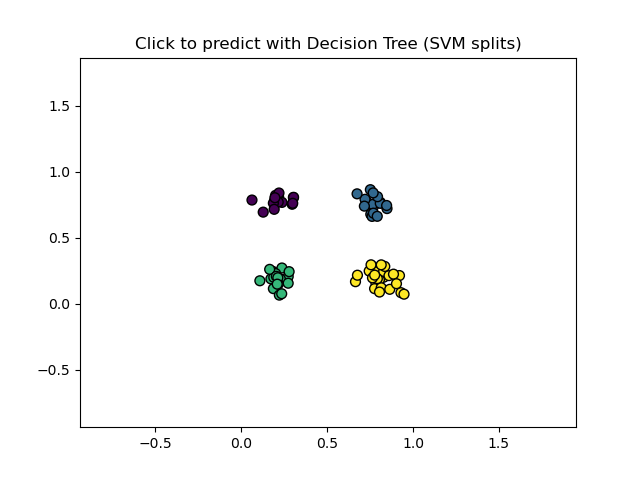

MAX_TREE_HEIGHT set to 3 for m = 4 classes.
Data2 accuracy:  0.24
[[24  0  0  0]
 [26  0  0  0]
 [21  0  0  0]
 [29  0  0  0]]
              precision    recall  f1-score   support

           1       0.24      1.00      0.39        24
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29

    accuracy                           0.24       100
   macro avg       0.06      0.25      0.10       100
weighted avg       0.06      0.24      0.09       100




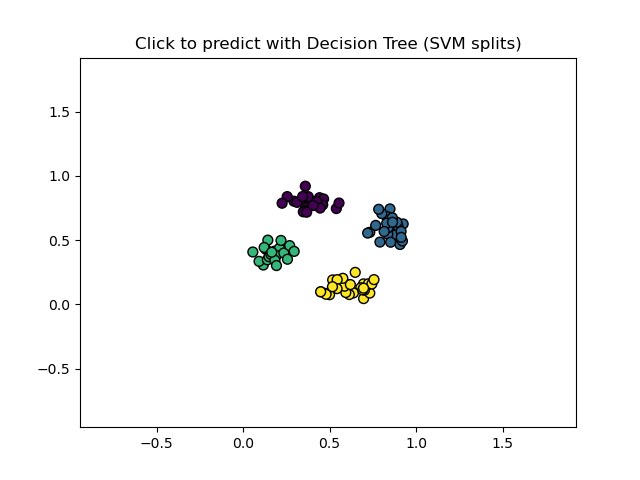

MAX_TREE_HEIGHT set to 3 for m = 3 classes.
Data3 accuracy:  0.3333333333333333
[[20  0  0]
 [20  0  0]
 [20  0  0]]
              precision    recall  f1-score   support

           1       0.33      1.00      0.50        20
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        20

    accuracy                           0.33        60
   macro avg       0.11      0.33      0.17        60
weighted avg       0.11      0.33      0.17        60




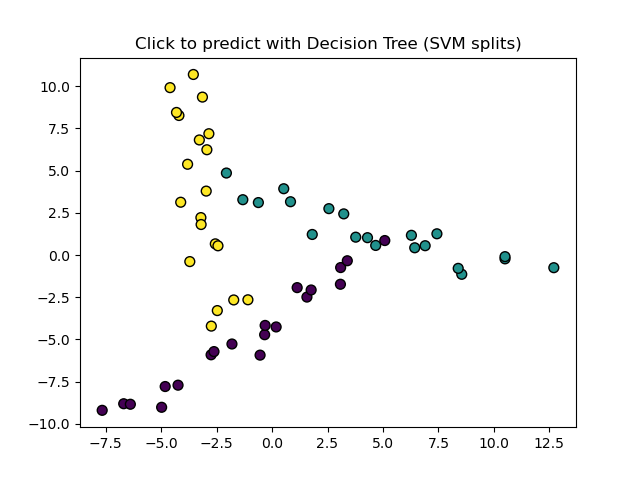

In [57]:
# data 1–3: (linear)
tree1, acc1, depth1, X1_test, y1_test = train_and_eval("data/data1/Data1Train.csv", "data/data1/Data1Test.csv", linear = True)

print("Data1 accuracy: ", acc1)
print(confusion_matrix(y1_test, predict(tree1, X1_test)))
print(classification_report(y1_test, predict(tree1, X1_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree1, X1_test, y1_test)

tree2, acc2, depth2, X2_test, y2_test = train_and_eval("data/data2/Data2Train.csv", "data/data2/Data2Test.csv", linear = True)

print("Data2 accuracy: ", acc2)
print(confusion_matrix(y2_test, predict(tree2, X2_test)))
print(classification_report(y2_test, predict(tree2, X2_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree2, X2_test, y2_test)

tree3, acc3, depth3, X3_test, y3_test = train_and_eval("data/data3/Data3Train.csv", "data/data3/Data3Test.csv", linear = True)

print("Data3 accuracy: ", acc3)
print(confusion_matrix(y3_test, predict(tree3, X3_test)))
print(classification_report(y3_test, predict(tree3, X3_test), zero_division = 0))
print("===========================================================\n")

interactive_plot(tree3, X3_test, y3_test)